# Process bulk counts table

1. Annotate columns (samples) in a way that time point and replicate are annotated
2. Remove rRNA genes
3. Perform TPM normalization and alternatively also raw counts

In [1]:
# Use miniconda environment Jupyter_new for running this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tools import *
import warnings
warnings.filterwarnings('ignore')

## 1 Load the dataset and annotation

In [2]:
bulkPath = '../nf_output_1/countData/countData.tsv'
metaPath = '../Sprenger[1]_SraRunTable.csv' # metadata from SRA
gffPath = '../nf_output_1/alignments/dualGenome.gff3' # output from nf pipeline

In [3]:
# Load data
df_initial = pd.read_csv(bulkPath, sep = '\t', comment='#', index_col=0)
df_initial = df_initial.drop(columns=['SRR26830476_sorted.bam', 'SRR26830477_sorted.bam', 'SRR26830478_sorted.bam', 
                                      'SRR26830479_sorted.bam', 'SRR26830480_sorted.bam', 'SRR26830481_sorted.bam', 
                                      'SRR26830482_sorted.bam', 'SRR26830483_sorted.bam', 'SRR26830484_sorted.bam'])
metadata = pd.read_csv(metaPath)
metadata = metadata[metadata['genotype'] == 'delta_tdh + JSP-1269 (VP882::kanR delta_vpdS)']

In [4]:
df_initial.head()

,Chr,Start,End,Strand,Length,SRR26830475_sorted.bam,SRR26830472_sorted.bam,SRR26830468_sorted.bam,SRR26830474_sorted.bam,SRR26830471_sorted.bam,SRR26830473_sorted.bam,SRR26830467_sorted.bam,SRR26830470_sorted.bam,SRR26830469_sorted.bam
Geneid,,,,,,,,,,,,,,
gene-VC_RS00005,NC_002505.1,372,806,-,435,531,401,322,403,480,522,327,345,230
gene-VC_RS00010,NC_002505.1,816,2177,-,1362,1277,1214,1508,1279,1506,1437,1528,1090,1371
gene-VC_RS00015,NC_002505.1,2271,3896,-,1626,2766,2761,3942,3121,3295,3820,4287,2830,3556
gene-VC_RS00020,NC_002505.1,3899,4156,-,258,769,902,1164,617,851,816,1206,666,851
gene-VC_RS00025,NC_002505.1,4123,4446,-,324,1178,1296,1595,1167,1889,1687,1508,1267,1151


In [5]:
pd.set_option('display.max_columns', None)  # Show all columns
metadata

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,collection_date,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,genotype,geo_loc_name_country,geo_loc_name_country_continent,geo_loc_name,Instrument,Library Name,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,strain,time
0,SRR26830467,RNA-Seq,101,1478462341,PRJNA1040289,SAMN38256628,516061023,"PAPENFORT LAB, INSTITUTE OF MICROBIOLOGY, FRIE...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX22526453,delta_tdh + JSP-1269 (VP882::kanR delta_vpdS),uncalculated,uncalculated,missing,NextSeq 1000,GSM7900526,SINGLE,cDNA,TRANSCRIPTOMIC,Vibrio cholerae C6706,ILLUMINA,2023-11-20T00:00:00Z,2023-11-14T22:25:00Z,1,GSM7900526,C6706,SRP471885,C6706,60 min
1,SRR26830468,RNA-Seq,101,1302964236,PRJNA1040289,SAMN38256629,474151716,"PAPENFORT LAB, INSTITUTE OF MICROBIOLOGY, FRIE...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX22526452,delta_tdh + JSP-1269 (VP882::kanR delta_vpdS),uncalculated,uncalculated,missing,NextSeq 1000,GSM7900525,SINGLE,cDNA,TRANSCRIPTOMIC,Vibrio cholerae C6706,ILLUMINA,2023-11-20T00:00:00Z,2023-11-14T22:24:00Z,1,GSM7900525,C6706,SRP471885,C6706,60 min
2,SRR26830469,RNA-Seq,101,1315535807,PRJNA1040289,SAMN38256630,457378468,"PAPENFORT LAB, INSTITUTE OF MICROBIOLOGY, FRIE...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX22526451,delta_tdh + JSP-1269 (VP882::kanR delta_vpdS),uncalculated,uncalculated,missing,NextSeq 1000,GSM7900524,SINGLE,cDNA,TRANSCRIPTOMIC,Vibrio cholerae C6706,ILLUMINA,2023-11-20T00:00:00Z,2023-11-14T22:25:00Z,1,GSM7900524,C6706,SRP471885,C6706,60 min
3,SRR26830470,RNA-Seq,101,1554889243,PRJNA1040289,SAMN38256631,562474076,"PAPENFORT LAB, INSTITUTE OF MICROBIOLOGY, FRIE...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX22526450,delta_tdh + JSP-1269 (VP882::kanR delta_vpdS),uncalculated,uncalculated,missing,NextSeq 1000,GSM7900523,SINGLE,cDNA,TRANSCRIPTOMIC,Vibrio cholerae C6706,ILLUMINA,2023-11-20T00:00:00Z,2023-11-14T22:25:00Z,1,GSM7900523,C6706,SRP471885,C6706,30 min
4,SRR26830471,RNA-Seq,101,1526312000,PRJNA1040289,SAMN38256632,535135467,"PAPENFORT LAB, INSTITUTE OF MICROBIOLOGY, FRIE...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX22526449,delta_tdh + JSP-1269 (VP882::kanR delta_vpdS),uncalculated,uncalculated,missing,NextSeq 1000,GSM7900522,SINGLE,cDNA,TRANSCRIPTOMIC,Vibrio cholerae C6706,ILLUMINA,2023-11-20T00:00:00Z,2023-11-14T22:25:00Z,1,GSM7900522,C6706,SRP471885,C6706,30 min
5,SRR26830472,RNA-Seq,101,1087661829,PRJNA1040289,SAMN38256633,380570662,"PAPENFORT LAB, INSTITUTE OF MICROBIOLOGY, FRIE...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX22526448,delta_tdh + JSP-1269 (VP882::kanR delta_vpdS),uncalculated,uncalculated,missing,NextSeq 1000,GSM7900521,SINGLE,cDNA,TRANSCRIPTOMIC,Vibrio cholerae C6706,ILLUMINA,2023-11-20T00:00:00Z,2023-11-14T22:25:00Z,1,GSM7900521,C6706,SRP471885,C6706,30 min
6,SRR26830473,RNA-Seq,101,1594529723,PRJNA1040289,SAMN38256634,558850807,"PAPENFORT LAB, INSTITUTE OF MICROBIOLOGY, FRIE...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX22526447,delta_tdh + JSP-1269 (VP882::kanR delta_vpdS),uncalculated,uncalculated,missing,NextSeq 1000,GSM7900520,SINGLE,cDNA,TRANSCRIPTOMIC,Vibrio cholerae C6706,ILLUMINA,2023-11-20T00:00:00Z,2023-11-14T22:27:00Z,1,GSM7900520,C6706,SRP471885,C6706,pre
7,SRR26830474,RNA-Seq,101,1260278505,PRJNA1040289,SAMN38256635,438030402,"PAPENFORT LAB, INSTITUTE OF MICROBIOLOGY, FRIE...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX22526446,delta_tdh + JSP-1269 (VP882::kanR delta_vpdS),uncalculated,uncalculated,missing,NextSeq 1000,GSM

## 2 Format the dataset

### 2.1 Annotate sample names

Issue now is that the metadata does not properly annotate sample names. Thus, this will be done manually by adding another sample name column to the metadata.

In [6]:
# Match GSM IDs and SampleNames inferred from GEO

sampleDict = {'GSM7900518': '0_R1', 'GSM7900519': '0_R2', 'GSM7900520': '0_R3',
              'GSM7900521': '30_R1', 'GSM7900522': '30_R2', 'GSM7900523': '30_R3',
              'GSM7900524': '60_R1', 'GSM7900525': '60_R2', 'GSM7900526': '60_R3'
}

In [7]:
metadataFull = annotateData(metadata, sampleDict)

In [8]:
metadata.head(1)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,collection_date,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,genotype,geo_loc_name_country,geo_loc_name_country_continent,geo_loc_name,Instrument,Library Name,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,strain,time
0,SRR26830467,RNA-Seq,101,1478462341,PRJNA1040289,SAMN38256628,516061023,"PAPENFORT LAB, INSTITUTE OF MICROBIOLOGY, FRIE...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX22526453,delta_tdh + JSP-1269 (VP882::kanR delta_vpdS),uncalculated,uncalculated,missing,NextSeq 1000,GSM7900526,SINGLE,cDNA,TRANSCRIPTOMIC,Vibrio cholerae C6706,ILLUMINA,2023-11-20T00:00:00Z,2023-11-14T22:25:00Z,1,GSM7900526,C6706,SRP471885,C6706,60 min


In [9]:
metadataFull.head(1)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,collection_date,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,genotype,geo_loc_name_country,geo_loc_name_country_continent,geo_loc_name,Instrument,Library Name,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,strain,time,SampleID,SampleNames
SampleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SRR26830467_sorted.bam,SRR26830467,RNA-Seq,101,1478462341,PRJNA1040289,SAMN38256628,516061023,"PAPENFORT LAB, INSTITUTE OF MICROBIOLOGY, FRIE...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX22526453,delta_tdh + JSP-1269 (VP882::kanR delta_vpdS),uncalculated,uncalculated,missing,NextSeq 1000,GSM7900526,SINGLE,cDNA,TRANSCRIPTOMIC,Vibrio cholerae C6706,ILLUMINA,2023-11-20T00:00:00Z,2023-11-14T22:25:00Z,1,GSM7900526,C6706,SRP471885,C6706,60 min,SRR26830467_sorted.bam,60_R3


Add correct sample names.

In [10]:
df = changeColnames(df_initial.iloc[:,5:df_initial.shape[1]], metadataFull)
df = df[['0_R1', '0_R2', '0_R3', '30_R1', '30_R2', '30_R3', '60_R1', '60_R2', '60_R3']]
df

SampleNames,0_R1,0_R2,0_R3,30_R1,30_R2,30_R3,60_R1,60_R2,60_R3
Geneid,,,,,,,,,
gene-VC_RS00005,531,403,522,401,480,345,230,322,327
gene-VC_RS00010,1277,1279,1437,1214,1506,1090,1371,1508,1528
gene-VC_RS00015,2766,3121,3820,2761,3295,2830,3556,3942,4287
gene-VC_RS00020,769,617,816,902,851,666,851,1164,1206
gene-VC_RS00025,1178,1167,1687,1296,1889,1267,1151,1595,1508
...,...,...,...,...,...,...,...,...,...
gene-VPVV882_gp67,327,262,330,478,751,610,758,1052,1104
gene-VPVV882_gp68,2289,2044,2293,4833,7964,7634,8217,13778,12921
gene-VPVV882_gp69,642,539,794,7827,9949,7630,37053,30220,30766


### 2.2 Remove rRNA genes

Consult gff3 file to get rRNA geneids.

In [11]:
# Load gff3 and split into genes and CDS dfs
gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3.columns=["seq_id", "source", "type", "start", "end", "phase", "strand", "score", "attributes"]
gff3_genes = gff3.loc[gff3["type"] == 'gene']

# Column formating for genes
gff3_genes = gff3_genes.reset_index(drop=True)
dct_genes = gff3_genes["attributes"].str.split(';').apply(lambda items: dict(item.split('=', 1) for item in items if '=' in item))
cols_to_keep = ['ID', 'Name', 'gbkey', 'gene_biotype', 'locus_tag', 'gene']
gff3_genes = pd.concat([gff3_genes, pd.json_normalize(dct_genes)[cols_to_keep]], axis=1)

# Generate locus_tag, product dictonary over all different feature types
attrs = gff3["attributes"].str.split(";", expand=True)
attrs_dicts = attrs.apply(lambda row: {item.split("=")[0]: item.split("=")[1] for item in row if "=" in str(item)}, axis=1)
attrs_df = pd.json_normalize(attrs_dicts)
attrs_df = attrs_df.dropna(subset=["locus_tag", "product"])
locus_product_dict = dict(zip(attrs_df["locus_tag"], attrs_df["product"]))

# Add gene product, if not stated in gff3, fill with gene_biotype
gff3_genes["product"] = gff3_genes["locus_tag"].map(locus_product_dict)
# gff3_genes["product"] = gff3_genes["product"].fillna("other")
gff3_genes["product"] = gff3_genes["product"].fillna(gff3_genes["gene_biotype"])

# If gene = NA, take from ID column
gff3_genes["gene"] = gff3_genes["gene"].fillna(gff3_genes["ID"])

# Drop attributes column
gff3_genes = gff3_genes.drop(["attributes"], axis=1)

In [12]:
pharokka_path = "../../../2025-12_reannotation_phage_genomes/Pharokka_proteins_phages_out/NC_009016.1_out/pharokka_proteins_full_merged_output.tsv"
gff3_genes = add_pharokka(gff3_genes, pharokka_path)
gff3_genes.loc[gff3_genes['seq_id'] == "NC_009016.1"]

,seq_id,source,type,start,end,phase,strand,score,ID,Name,gbkey,gene_biotype,locus_tag,gene,product,annot,PHROG,category
3612,NC_009016.1,RefSeq,gene,132.0,353.0,.,-,.,gene-VPVV882_gp01,VPVV882_gp01,Gene,protein_coding,VPVV882_gp01,gene-VPVV882_gp01,hypothetical protein,hypothetical protein,No_PHROG,unknown function
3613,NC_009016.1,RefSeq,gene,208.0,774.0,.,+,.,gene-VPVV882_gp02,VPVV882_gp02,Gene,protein_coding,VPVV882_gp02,gene-VPVV882_gp02,terminase small subunit,terminase small subunit,57,head and packaging
3614,NC_009016.1,RefSeq,gene,353.0,604.0,.,-,.,gene-VPVV882_gp03,VPVV882_gp03,Gene,protein_coding,VPVV882_gp03,gene-VPVV882_gp03,hypothetical protein,hypothetical protein,No_PHROG,unknown function
3615,NC_009016.1,RefSeq,gene,608.0,2677.0,.,+,.,gene-VPVV882_gp04,VPVV882_gp04,Gene,protein_coding,VPVV882_gp04,gene-VPVV882_gp04,terminase large subunit,terminase large subunit,15,head and packaging
3616,NC_009016.1,RefSeq,gene,2674.0,3204.0,.,+,.,gene-VPVV882_gp05,VPVV882_gp05,Gene,protein_coding,VPVV882_gp05,gene-VPVV882_gp05,head-tail joining,head-tail joining,5774,connector
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3678,NC_009016.1,RefSeq,gene,35744.0,35920.0,.,+,.,gene-VPVV882_gp67,VPVV882_gp67,Gene,protein_coding,VPVV882_gp67,gene-VPVV882_gp67,hypothetical protein,hypothetical protein,No_PHROG,unknown function
3679,NC_009016.1,RefSeq,gene,35996.0,36367.0,.,+,.,gene-VPVV882_gp68,VPVV882_gp68,Gene,protein_coding,VPVV882_gp68,gene-VPVV882_gp68,hypothetical protein,hypothetical protein,No_PHROG,unknown function
3680,NC_009016.1,RefSeq,gene,36563.0,36835.0,.,+,.,gene-VPVV882_gp69,VPVV882_gp69,Gene,protein_coding,VPVV882_gp69,gene-VPVV882_gp69,putative phage-related protein,hypothetical protein,7885,unknown function
3681,NC_009016.1,RefSeq,gene,36835.0,37389.0,.,+,.,gene-VPVV882_gp70,VPVV882_gp70,Gene,protein_coding,VPVV882_gp70,gene-VPVV882_gp70,endolysin,endolysin,315,lysis


In [13]:
# Load ggf3 file

gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3 = gff3.loc[gff3.iloc[:,2] == 'gene']

# Format some new columns
gff3['ID'] = pd.DataFrame(gff3.iloc[:,8].str.split('ID=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['GeneType'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene_biotype=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['Symbol'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]

# Add entity host and phage
gff3['Entity'] = np.where(gff3[0] == 'NC_009016.1', 'phage', 'host')
gff3.index = gff3['ID']
rRNAs = gff3.loc[gff3['GeneType'] == 'rRNA', 'ID'].tolist()

Perform in silico rRNA depletion.

In [14]:
df_norRNAs = rRNAdepletion(df,rRNAs)
df_norRNAs

SampleNames,0_R1,0_R2,0_R3,30_R1,30_R2,30_R3,60_R1,60_R2,60_R3
Geneid,,,,,,,,,
gene-VC_RS17170,342,402,496,414,544,492,877,1159,1240
gene-VC_RS14125,110,105,124,109,133,132,170,212,211
gene-VC_RS08575,149,119,153,156,203,134,194,236,254
gene-VC_RS10955,2207,2202,2629,3101,3292,2694,3703,4195,3980
gene-VC_RS11895,346,346,432,264,253,282,196,233,243
...,...,...,...,...,...,...,...,...,...
gene-VC_RS08810,166,165,181,118,173,127,239,249,280
gene-VC_RS15800,831,848,1104,743,725,731,918,900,966
gene-VC_RS12705,225,250,349,202,249,191,189,212,241


### 2.3 Read count normalization

Important note: gene symbols not available for most genes.

In [15]:
# Function to fill in missing symbols by geneid.

def fillSymbols(df):
    df_new = df.copy()
    index = df.index.to_list()
    for i in range(0,df.shape[0]):
        if (df.iloc[i,-1:].values == None):
            df_new.iloc[i,-1:] = index[i]
    return df_new

Convert counts to TPM.

In [16]:
tpms = TPM(df_norRNAs, df_initial, 0.5)
tpms['Entity'] = gff3.loc[sorted(tpms.index.to_list()), 'Entity']
tpms['Symbol'] = gff3.loc[sorted(tpms.index.to_list()), 'Symbol']

tpms = fillSymbols(tpms)
tpms = make_unique_with_index(tpms)
tpms

SampleNames,0_R1,0_R2,0_R3,30_R1,30_R2,30_R3,60_R1,60_R2,60_R3,Entity,Symbol
Geneid,,,,,,,,,,,
gene-VC_RS17170,22.396344,23.849043,25.522890,28.923004,30.994080,27.469092,54.100996,68.546229,66.416047,host,gene-VC_RS17170
gene-VC_RS14125,6.645183,5.748912,5.885835,7.026857,6.988601,6.796449,9.667421,11.553135,10.413932,host,tnaA
gene-VC_RS08575,14.222496,10.301277,11.479872,15.887343,16.852462,10.913861,17.445998,20.340519,19.823581,host,gene-VC_RS08575
gene-VC_RS10955,399.951078,361.585161,374.518593,599.625717,519.273615,416.395336,632.645017,687.204734,590.477684,host,ribE
gene-VC_RS11895,85.705997,77.660420,84.098477,69.812944,54.582101,59.600230,45.826017,52.214499,49.313592,host,gene-VC_RS11895
...,...,...,...,...,...,...,...,...,...,...,...
gene-VC_RS08810,16.914611,15.234714,14.495008,12.846015,15.343045,11.047893,22.940078,22.914722,23.331376,host,gene-VC_RS08810
gene-VC_RS15800,118.260053,109.349345,123.491079,112.838965,89.820930,88.738413,123.167623,115.785931,112.547895,host,gene-VC_RS15800
gene-VC_RS12705,18.921374,19.045938,23.054056,18.131488,18.223885,13.705548,14.991908,16.119861,16.591397,host,pilM


In [17]:
# Check gene names unique
len(tpms['Symbol'].unique())

3658

Log2+1 normalization raw counts

In [18]:
logs = logNorm(df_norRNAs)
logs['Entity'] = gff3.loc[sorted(logs.index.to_list()), 'Entity']
logs['Symbol'] = gff3.loc[sorted(logs.index.to_list()), 'Symbol']
logs = fillSymbols(logs)
# Make gene names unique
logs = make_unique_with_index(logs)
logs

SampleNames,0_R1,0_R2,0_R3,30_R1,30_R2,30_R3,60_R1,60_R2,60_R3,Entity,Symbol
Geneid,,,,,,,,,,,
gene-VC_RS17170,8.422065,8.654636,8.957102,8.696968,9.090112,8.945444,9.778077,10.179909,10.277287,host,gene-VC_RS17170
gene-VC_RS14125,6.794416,6.727920,6.965784,6.781360,7.066089,7.055282,7.417853,7.734710,7.727920,host,tnaA
gene-VC_RS08575,7.228819,6.906891,7.266787,7.294621,7.672425,7.076816,7.607330,7.888743,7.994353,host,gene-VC_RS08575
gene-VC_RS10955,11.108524,11.105254,11.360847,11.598983,11.685187,11.396070,11.854868,12.034799,11.958915,host,ribE
gene-VC_RS11895,8.438792,8.438792,8.758223,8.049849,7.988685,8.144658,7.622052,7.870365,7.930737,host,gene-VC_RS11895
...,...,...,...,...,...,...,...,...,...,...,...
gene-VC_RS08810,7.383704,7.375039,7.507795,6.894818,7.442943,7.000000,7.906891,7.965784,8.134426,host,gene-VC_RS08810
gene-VC_RS15800,9.700440,9.729621,10.109831,9.539159,9.503826,9.515700,9.843921,9.815383,9.917372,host,gene-VC_RS15800
gene-VC_RS12705,7.820179,7.971544,8.451211,7.665336,7.965784,7.584963,7.569856,7.734710,7.918863,host,pilM


Log2+1 normalization tpms

In [19]:
logTPMs = logNorm(tpms.iloc[:, :-2])
logTPMs = logTPMs.join(tpms.iloc[:, -2:])
logTPMs = fillSymbols(logTPMs)
# Make gene names unique
logTPMs = make_unique_with_index(logTPMs)
logTPMs

SampleNames,0_R1,0_R2,0_R3,30_R1,30_R2,30_R3,60_R1,60_R2,60_R3,Entity,Symbol
Geneid,,,,,,,,,,,
gene-VC_RS17170,4.548211,4.635118,4.729166,4.903183,4.999733,4.831325,5.784007,6.119900,6.075020,host,gene-VC_RS17170
gene-VC_RS14125,2.934551,2.754655,2.783632,3.004835,2.997943,2.962817,3.415140,3.649976,3.512724,host,tnaA
gene-VC_RS08575,3.928133,3.498414,3.641531,4.077870,4.158051,3.574569,4.205236,4.415523,4.380146,host,gene-VC_RS08575
gene-VC_RS10955,8.647282,8.502176,8.552741,9.230322,9.023127,8.705271,9.307531,9.426694,9.208180,host,ribE
gene-VC_RS11895,6.438060,6.297566,6.411061,6.145941,5.796548,5.921251,5.549238,5.733747,5.652876,host,gene-VC_RS11895
...,...,...,...,...,...,...,...,...,...,...,...
gene-VC_RS08810,4.163065,4.021010,3.953732,3.791399,4.030605,3.590709,4.581356,4.579827,4.604746,host,gene-VC_RS08810
gene-VC_RS15800,6.897967,6.785934,6.959899,6.830851,6.504953,6.487654,6.956145,6.867723,6.827157,host,gene-VC_RS15800
gene-VC_RS12705,4.316245,4.325238,4.588208,4.257877,4.264828,3.878289,3.999270,4.097599,4.136798,host,pilM


## 3 Filter samples, if necessary

Look for outliers visually by PCA.

In [20]:
columnOrder = ['0_R1', '0_R2', '0_R3', '30_R1', '30_R2', '30_R3', '60_R1', '60_R2', '60_R3']

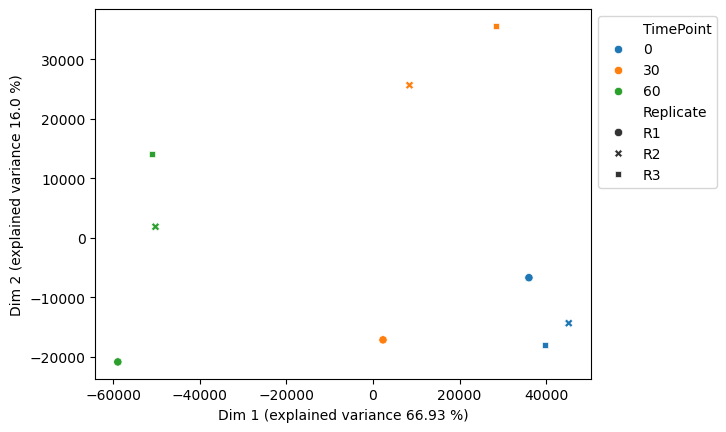

In [21]:
txPCA(tpms[columnOrder])

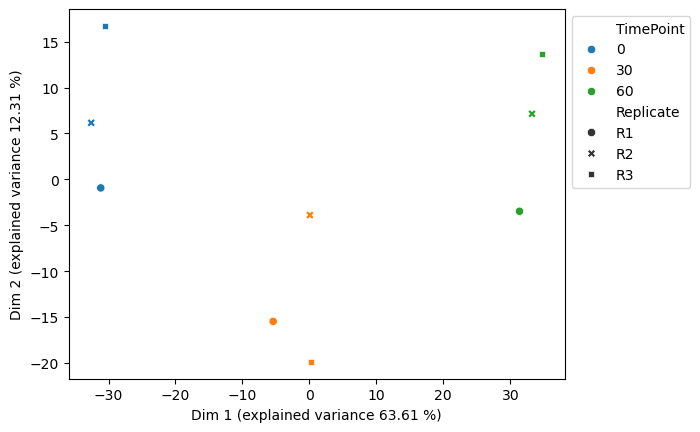

In [22]:
txPCA(logs[columnOrder])

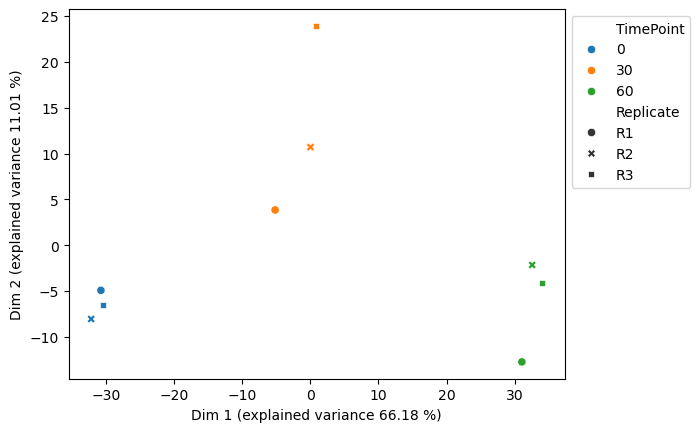

In [23]:
txPCA(logTPMs[columnOrder])

In [24]:
tpmHost = tpms[tpms['Entity'] == 'host']
tpmPhage = tpms[tpms['Entity'] == 'phage']
logTPMsHost = logTPMs[logTPMs['Entity'] == 'host']
logTPMsPhage = logTPMs[logTPMs['Entity'] == 'phage']

tpmHost

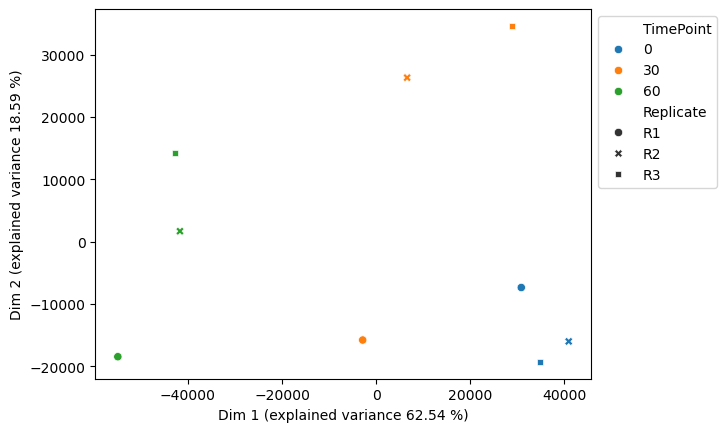

In [25]:
txPCA(tpmHost[columnOrder])

tpmPhage

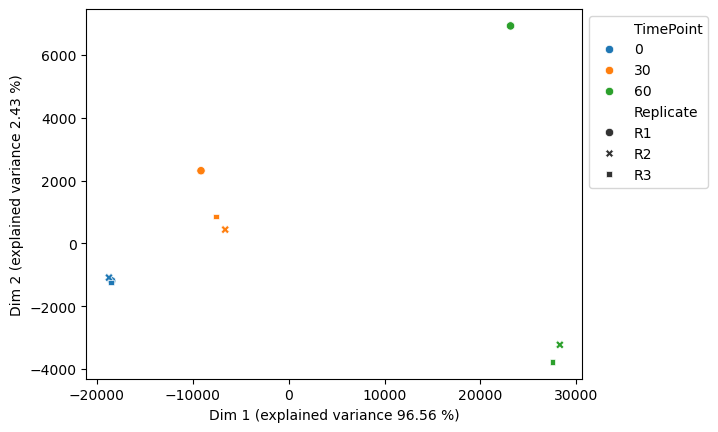

In [26]:
txPCA(tpmPhage[columnOrder])

logTPM Host

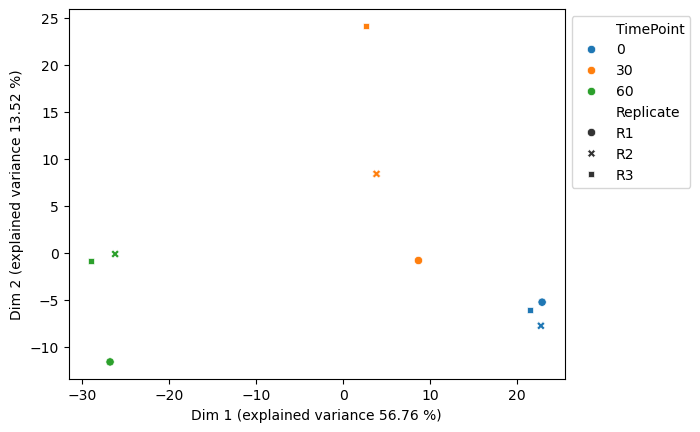

In [27]:
txPCA(logTPMsHost[columnOrder])

logTPM Phage

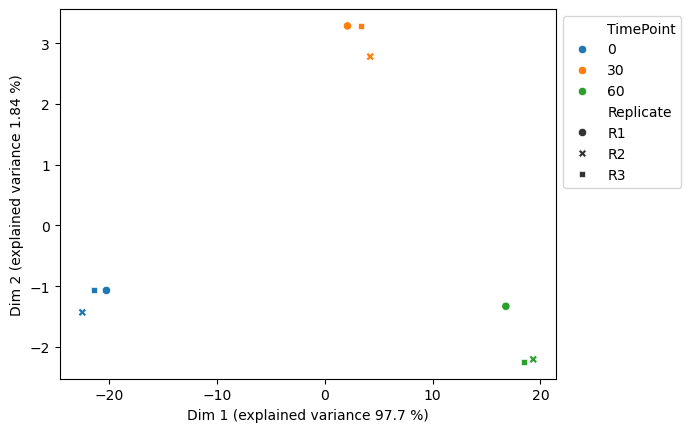

In [28]:
txPCA(logTPMsPhage[columnOrder])

$\rightarrow$ Replicates 30_R1 and 60_R1 seem to be a bit off. Check PCA without them

## 3.2 PCA's without 30_R1 and 60_R1

In [29]:
updatedOrder = ['0_R1', '0_R2', '0_R3', '30_R2', '30_R3', '60_R2', '60_R3']

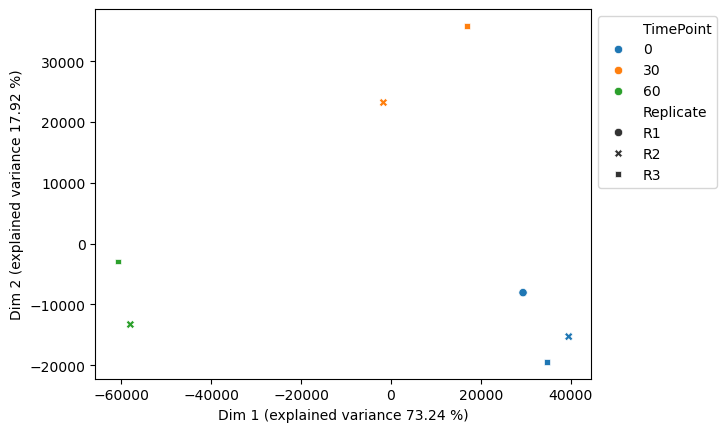

In [30]:
txPCA(tpms[updatedOrder])

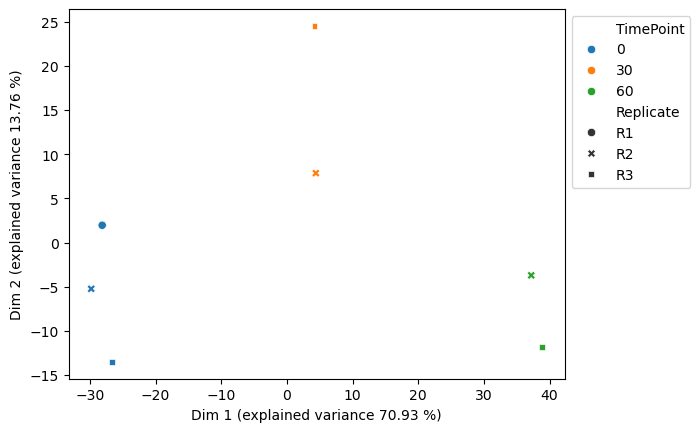

In [31]:
txPCA(logs[updatedOrder])

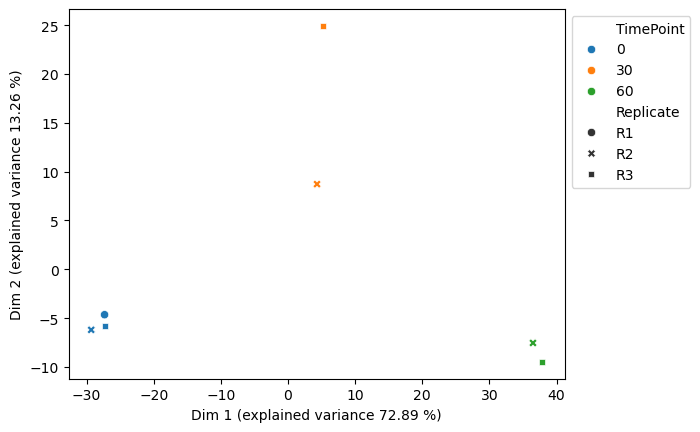

In [32]:
txPCA(logTPMs[updatedOrder])

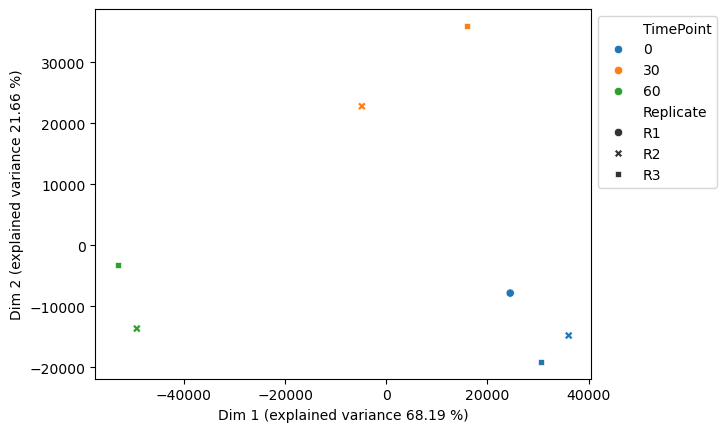

In [33]:
txPCA(tpmHost[updatedOrder])

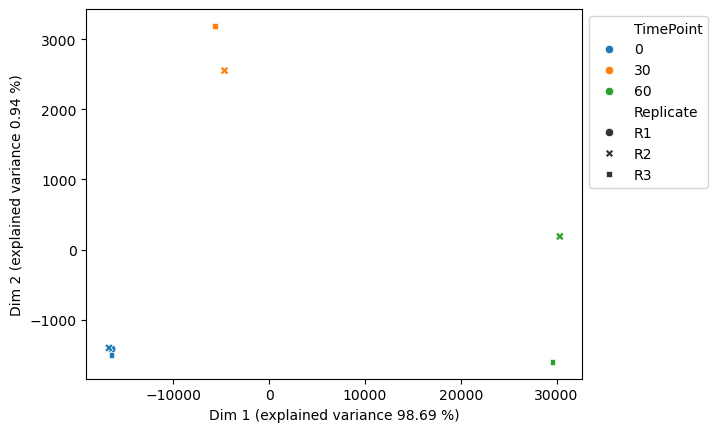

In [34]:
txPCA(tpmPhage[updatedOrder])

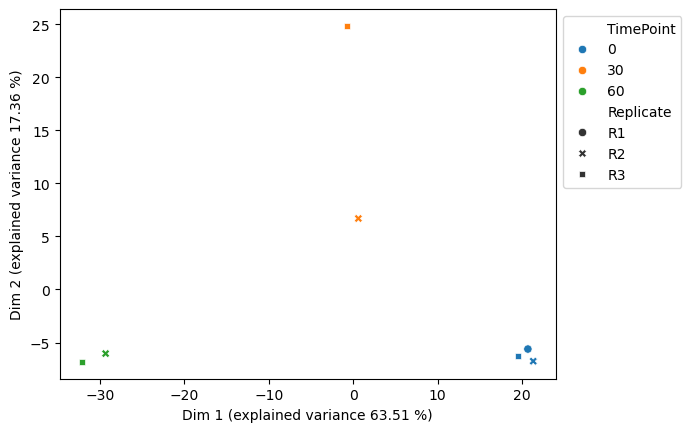

In [35]:
txPCA(logTPMsHost[updatedOrder])

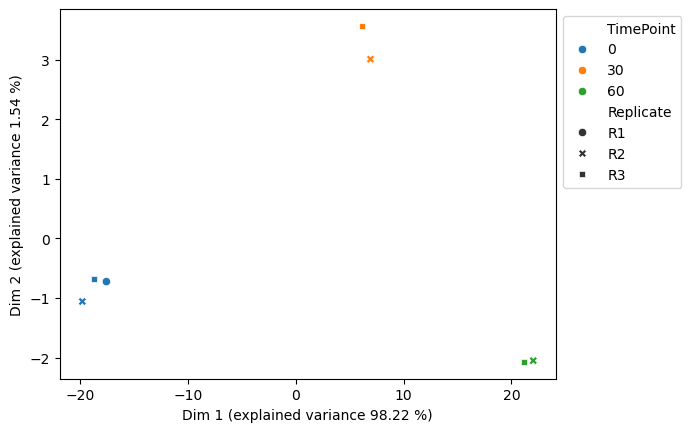

In [36]:
txPCA(logTPMsPhage[updatedOrder])

I would again keep all samples, especially since samples align mostly very well along Dim1. For example, 60_R1 in tpmPhage PCA with all replicates seems far off, but only in Dim2, which explains only very small amount of variance.

## 4. Final grouping

Summarize time points with mean and standard deviation for TPM-normalized data.

In [37]:
TPMmeans, TPMsds = getMeanSD(tpms[columnOrder])
TPMmeans = TPMmeans[['0', '30', '60']]
TPMmeans[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMmeans

,0,30,60,Entity,Symbol
Geneid,,,,,
gene-VC_RS17170,23.922759,29.128725,63.021091,host,gene-VC_RS17170
gene-VC_RS14125,6.093310,6.937302,10.544830,host,tnaA
gene-VC_RS08575,12.001215,14.551222,19.203366,host,gene-VC_RS08575
gene-VC_RS10955,378.684944,511.764889,636.775812,host,ribE
gene-VC_RS11895,82.488298,61.331758,49.118036,host,gene-VC_RS11895
...,...,...,...,...,...
gene-VC_RS08810,15.548111,13.078985,23.062058,host,gene-VC_RS08810
gene-VC_RS15800,117.033492,97.132769,117.167149,host,gene-VC_RS15800
gene-VC_RS12705,20.340456,16.686974,15.901055,host,pilM


In [38]:
TPMsds = TPMsds[['0', '30', '60']]
TPMsds[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMsds

,0,30,60,Entity,Symbol
Geneid,,,,,
gene-VC_RS17170,1.277471,1.446404,6.367128,host,gene-VC_RS17170
gene-VC_RS14125,0.394216,0.100815,0.775384,host,tnaA
gene-VC_RS08575,1.642729,2.602007,1.260440,host,gene-VC_RS08575
gene-VC_RS10955,15.937477,74.991683,39.596533,host,ribE
gene-VC_RS11895,3.476333,6.337365,2.611750,host,gene-VC_RS11895
...,...,...,...,...,...
gene-VC_RS08810,1.012351,1.761210,0.190717,host,gene-VC_RS08810
gene-VC_RS15800,5.838122,11.114747,4.444133,host,gene-VC_RS15800
gene-VC_RS12705,1.919479,2.108524,0.671068,host,pilM


In [39]:
propExp = proportionalExp(TPMmeans[['0', '30', '60']])
propExp[['Entity', 'Symbol']] = TPMmeans[['Entity', 'Symbol']]
propExp

,0,30,60,Entity,Symbol
Geneid,,,,,
gene-VC_RS17170,0.379599,0.462206,1.000000,host,gene-VC_RS17170
gene-VC_RS14125,0.577848,0.657887,1.000000,host,tnaA
gene-VC_RS08575,0.624954,0.757743,1.000000,host,gene-VC_RS08575
gene-VC_RS10955,0.594691,0.803681,1.000000,host,ribE
gene-VC_RS11895,1.000000,0.743521,0.595455,host,gene-VC_RS11895
...,...,...,...,...,...
gene-VC_RS08810,0.674186,0.567121,1.000000,host,gene-VC_RS08810
gene-VC_RS15800,0.998859,0.829010,1.000000,host,gene-VC_RS15800
gene-VC_RS12705,1.000000,0.820383,0.781745,host,pilM


## 5. Phage gene classification

Similar to Sprenger VP882_WT, no classification specified in paper. Thus 0 -> early, 30 -> middle, 60 -> late.

In [40]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelThreshold(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-2)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM*0.2

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x >= thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('early')
        elif timePoint == 1:
            labels.append('middle')
        elif timePoint == 2:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassThreshold'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassThreshold'] = 'None'

    return tpmOut

In [41]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelMax(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-3)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x == thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('early')
        elif timePoint == 1:
            labels.append('middle')
        elif timePoint == 2:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassMax'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassMax'] = 'None'

    return tpmOut

In [42]:
TPMmeans = classLabelThreshold(TPMmeans)
TPMmeans = classLabelMax(TPMmeans)

In [43]:
TPMmeans

,0,30,60,Entity,Symbol,ClassThreshold,ClassMax
Geneid,,,,,,,
gene-VC_RS17170,23.922759,29.128725,63.021091,host,gene-VC_RS17170,None,None
gene-VC_RS14125,6.093310,6.937302,10.544830,host,tnaA,None,None
gene-VC_RS08575,12.001215,14.551222,19.203366,host,gene-VC_RS08575,None,None
gene-VC_RS10955,378.684944,511.764889,636.775812,host,ribE,None,None
gene-VC_RS11895,82.488298,61.331758,49.118036,host,gene-VC_RS11895,None,None
...,...,...,...,...,...,...,...
gene-VC_RS08810,15.548111,13.078985,23.062058,host,gene-VC_RS08810,None,None
gene-VC_RS15800,117.033492,97.132769,117.167149,host,gene-VC_RS15800,None,None
gene-VC_RS12705,20.340456,16.686974,15.901055,host,pilM,None,None


In [44]:
TPMmeans[TPMmeans['Entity'] == 'phage']['ClassMax'].value_counts()

ClassMax
late    71
Name: count, dtype: int64

Add classes to other dfs.

In [45]:
TPMsds[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
tpms[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
logs[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
propExp[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]

# gff3
gff3_final = gff3_genes.merge(TPMmeans[["ClassThreshold", "ClassMax"]], right_index=True, left_on="ID", how="left")
gff3_host  = gff3_final[gff3_final['seq_id'] != 'NC_009016.1']
gff3_phage = gff3_final[gff3_final['seq_id'] == 'NC_009016.1']
gff3_genes["seq_id"].unique()

array(['NC_002505.1', 'NC_002506.1', 'NC_009016.1'], dtype=object)

## 6. Add variance to all dataframes

Base variance call on tpms.

In [46]:
def stabilizedVariance(df):
    labels = list()
    
    i = 0
    while i < df.shape[0]:

        # Get array of expression values at time points
        expressions = list(df.iloc[i,0:(df.shape[1]-4)])

        # Get mean expression for the gene
        exprMean = np.mean(np.array(expressions))

        # Get the variance for the gene
        varGene = np.var(np.array(expressions))

        # Stabilized variance
        stableVarGene = varGene/exprMean

        labels.append(stableVarGene)

        i += 1

    tpmOut = df.copy()
    tpmOut['Variance'] = labels

    return tpmOut

In [47]:
tpms = stabilizedVariance(tpms)
tpms

SampleNames,0_R1,0_R2,0_R3,30_R1,30_R2,30_R3,60_R1,60_R2,60_R3,Entity,Symbol,ClassThreshold,ClassMax,Variance
Geneid,,,,,,,,,,,,,,
gene-VC_RS17170,22.396344,23.849043,25.522890,28.923004,30.994080,27.469092,54.100996,68.546229,66.416047,host,gene-VC_RS17170,None,None,8.147968
gene-VC_RS14125,6.645183,5.748912,5.885835,7.026857,6.988601,6.796449,9.667421,11.553135,10.413932,host,tnaA,None,None,0.506784
gene-VC_RS08575,14.222496,10.301277,11.479872,15.887343,16.852462,10.913861,17.445998,20.340519,19.823581,host,gene-VC_RS08575,None,None,0.824588
gene-VC_RS10955,399.951078,361.585161,374.518593,599.625717,519.273615,416.395336,632.645017,687.204734,590.477684,host,ribE,None,None,26.690189
gene-VC_RS11895,85.705997,77.660420,84.098477,69.812944,54.582101,59.600230,45.826017,52.214499,49.313592,host,gene-VC_RS11895,None,None,3.261069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-VC_RS08810,16.914611,15.234714,14.495008,12.846015,15.343045,11.047893,22.940078,22.914722,23.331376,host,gene-VC_RS08810,None,None,1.126652
gene-VC_RS15800,118.260053,109.349345,123.491079,112.838965,89.820930,88.738413,123.167623,115.785931,112.547895,host,gene-VC_RS15800,None,None,1.337573
gene-VC_RS12705,18.921374,19.045938,23.054056,18.131488,18.223885,13.705548,14.991908,16.119861,16.591397,host,pilM,None,None,0.374188


In [48]:
logs['Variance'] = tpms['Variance']
TPMmeans['Variance'] = tpms['Variance']
TPMsds['Variance'] = tpms['Variance']
propExp['Variance'] = tpms['Variance']

## 7. Write data to output

In [49]:
df_norRNAs[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]

In [50]:
# Full TPM table
tpms.to_csv('Sprenger_VP882_delta_vpdS_full_TPM.tsv', sep = '\t')
# Full raw_counts table
df_norRNAs.to_csv('Sprenger_VP882_delta_vpdS_full_raw_counts.tsv', sep = '\t')
# Summarized (time point means) TPM table
TPMmeans.to_csv('Sprenger_VP882_delta_vpdS_TPM_means.tsv', sep = '\t')
# Summarized (time point) TPM standard deviation
TPMsds.to_csv('Sprenger_VP882_delta_vpdS_TPM_std.tsv', sep = '\t')
# Proportional expression per gene and time point
propExp.to_csv('Sprenger_VP882_delta_vpdS_fractional_expression.tsv', sep = '\t')
# Processed gff3 file
gff3_host.to_csv('Sprenger_VP882_delta_vpdS_host_gff3.tsv', sep='\t')
gff3_phage.to_csv('Sprenger_VP882_delta_vpdS_phage_gff3.tsv', sep='\t')